https://www.kaggle.com/code/olyatsimboy/towards-tf-idf-in-logs-features

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/'My Drive'/'kaggle'/'LinkingWritingProcess'

/content/drive/My Drive/kaggle/LinkingWritingProcess


In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.8/226.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 1.4 MB/s eta 0:00:00


## (1) Imports

In [4]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from collections import Counter
from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

import optuna

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [5]:
tqdm.pandas()

sns.set_style('whitegrid')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
warnings.simplefilter('ignore')

import random
random.seed(42)

## (2) Load data

In [6]:
#INPUT_DIR = '/kaggle/input/linking-writing-processes-to-writing-quality'
INPUT_DIR = './data'

train_logs = pd.read_csv(f'{INPUT_DIR}/train_logs.csv')
train_scores = pd.read_csv(f'{INPUT_DIR}/train_scores.csv')
test_logs = pd.read_csv(f'{INPUT_DIR}/test_logs.csv')

submission = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')

In [7]:
train_logs.shape, train_scores.shape, test_logs.shape, submission.shape

((8405898, 11), (2471, 2), (6, 11), (3, 2))

In [8]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [9]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [10]:
train_scores.describe()

,score
count,2471.000000
mean,3.711251
std,1.024937
min,0.500000
25%,3.000000
50%,4.000000
75%,4.500000
max,6.000000


## (3) EDA

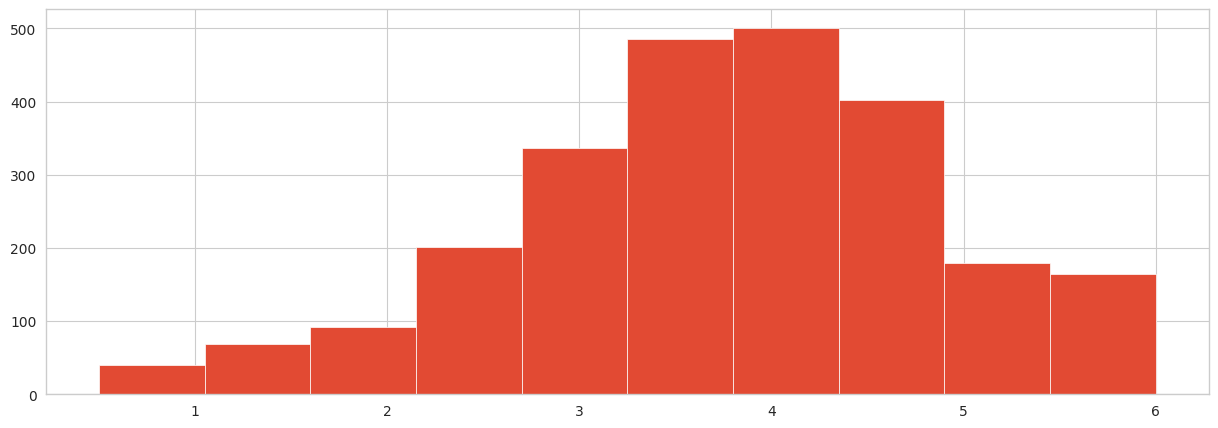

In [11]:
plt.figure(figsize=(15, 5))
train_scores['score'].hist()
plt.show()

In [12]:
train_scores['score'].value_counts()

4.0    501
3.5    486
4.5    402
3.0    336
2.5    201
5.0    179
5.5    128
2.0     92
1.5     69
6.0     37
1.0     35
0.5      5
Name: score, dtype: int64

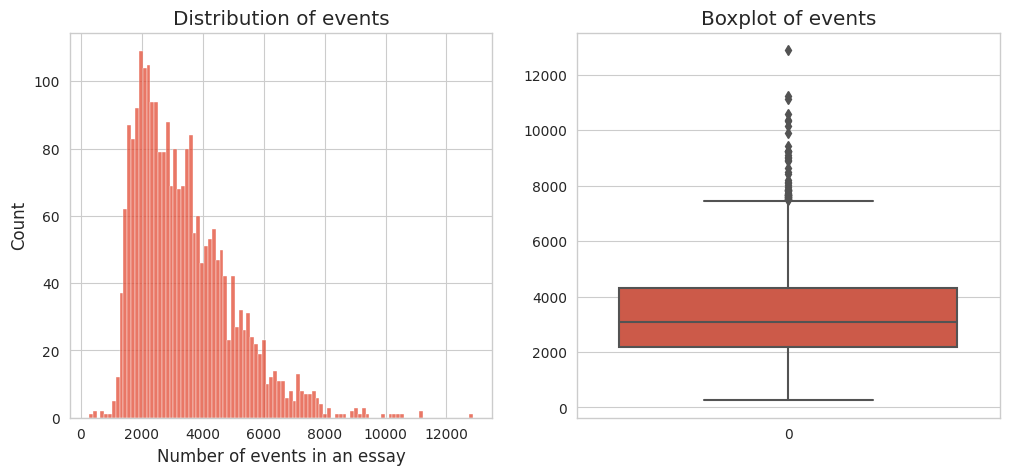

In [13]:
event_stats = train_logs.groupby('id')['event_id'].count()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].set_title('Distribution of events')
ax[0].set_xlabel('Number of events in an essay')
sns.histplot(event_stats, bins=100, ax=ax[0])
ax[1].set_title('Boxplot of events')
sns.boxplot(event_stats, ax=ax[1])
plt.show()

In [14]:
event_stats.describe()

count     2471.000000
mean      3401.820316
std       1578.850387
min        262.000000
25%       2193.500000
50%       3082.000000
75%       4301.000000
max      12876.000000
Name: event_id, dtype: float64

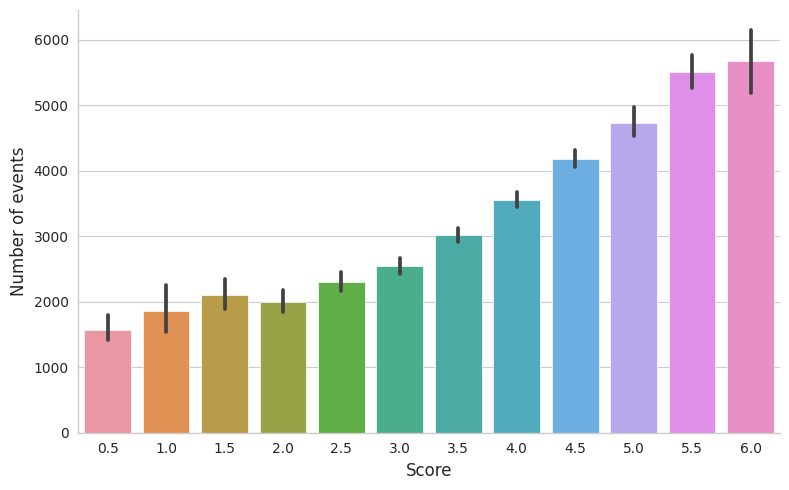

In [15]:
stats = train_logs.groupby('id')['event_id'].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x='score', y='event_id', kind='bar', height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Number of events', fontsize=12)
plt.show()

In [16]:
tmp = train_logs['up_time'] - train_logs['down_time']
results = (tmp == train_logs['action_time'])
results.value_counts()

True    8405898
dtype: int64

In [17]:
train_logs_scores_df = train_logs.merge(train_scores, on='id', how='left')
train_logs_scores_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count,score
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0,3.5
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0,3.5
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1,3.5
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1,3.5


In [18]:
train_logs_scores_df.columns

Index(['id', 'event_id', 'down_time', 'up_time', 'action_time', 'activity',
       'down_event', 'up_event', 'text_change', 'cursor_position',
       'word_count', 'score'],
      dtype='object')

In [19]:
train_logs_agg_df = train_logs_scores_df.groupby('id')[['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count', 'score']].mean().reset_index()
train_logs_agg_df

,id,down_time,up_time,action_time,cursor_position,word_count,score
0,001519c8,8.481808e+05,8.482970e+05,116.246774,711.163473,128.116152,3.5
1,0022f953,5.188553e+05,5.189676e+05,112.221271,776.205786,182.714751,3.5
2,0042269b,8.284918e+05,8.285936e+05,101.837766,731.611702,194.772727,6.0
3,0059420b,7.854830e+05,7.856049e+05,121.848329,542.537275,103.618895,2.0
4,0075873a,7.133542e+05,7.134781e+05,123.943896,600.050968,125.082971,4.0
...,...,...,...,...,...,...,...
2466,ffb8c745,7.361019e+05,7.362073e+05,105.437856,774.000633,256.353661,3.5
2467,ffbef7e5,8.419662e+05,8.420485e+05,82.266129,1022.078725,223.013057,4.0
2468,ffccd6fd,1.229015e+06,1.229091e+06,75.605615,1309.085537,157.589292,1.5
2469,ffec5b38,5.765185e+05,5.766078e+05,89.277915,1192.640962,205.917027,5.0


In [20]:
def plot_dist_box(data, target):
  color = choice(color_pal)

  # Create a figure with two subplot
  fig, axes = plt.subplots(1, 4, figsize=(15, 4))

  # Plot the distribution plot on the first subplot
  sns.histplot(data, ax=axes[0], color=color)
  axes[0].set_title('Distribution Plot')

  # Plot the box plot on the second subplot
  sns.boxplot(data, ax=axes[1], color=color)
  axes[1].set_title('Box Plot')

  # Plot the box plot on the second subplot
  sns.ecdfplot(data, ax=axes[2], color=color)
  axes[2].set_title('CDF Plot')

  # Plot the box plot on the second subplot
  sns.scatterplot(x=data, y=target, ax=axes[3], color=color)
  axes[3].set_title('Scatter Plot')

  # Adjust the spacing between subplots
  plt.tight_layout()
  plt.show()

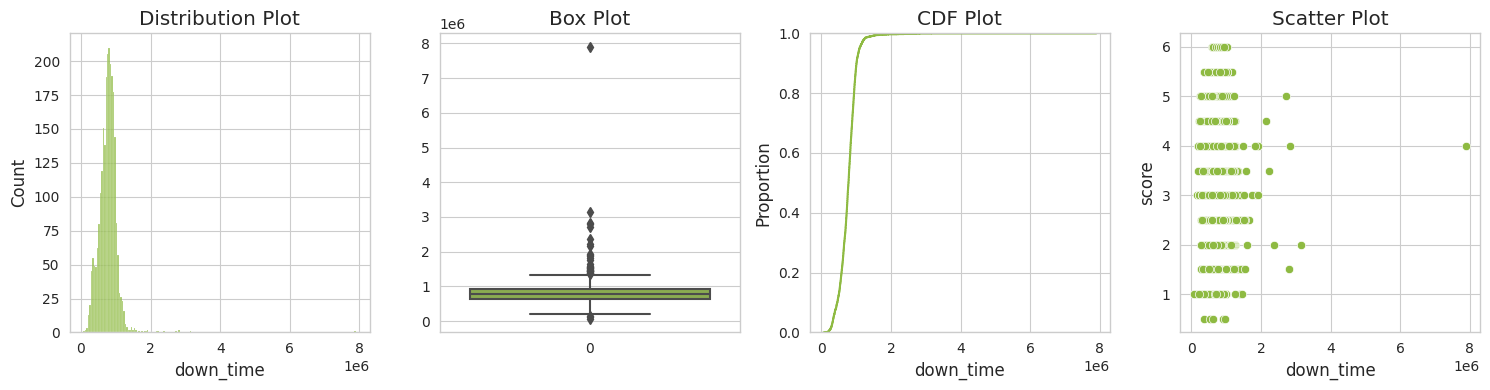

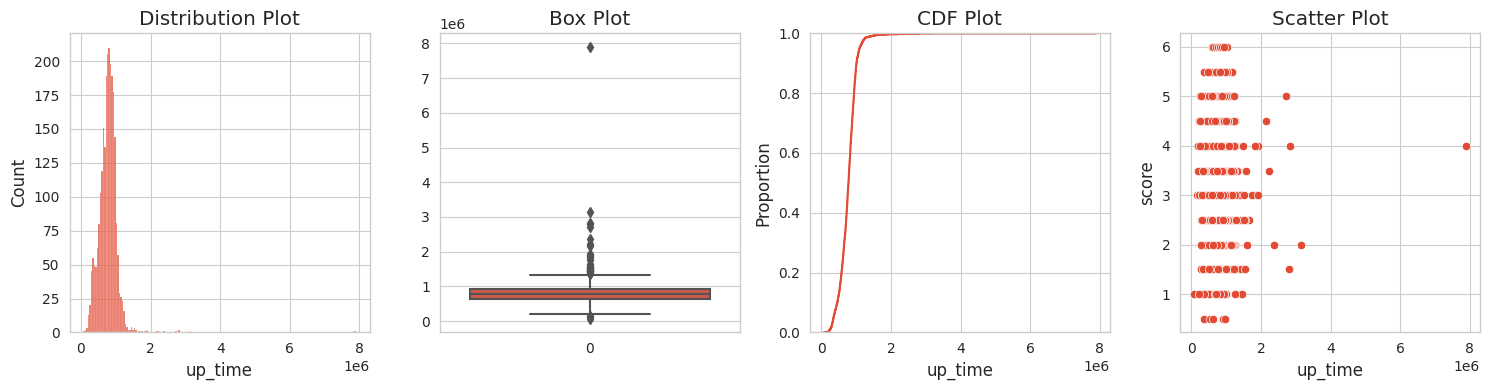

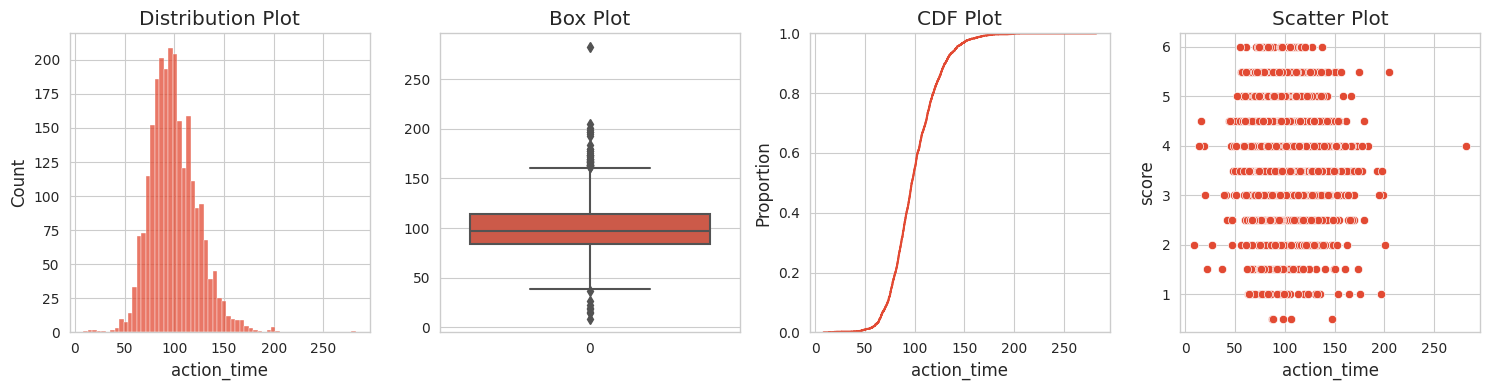

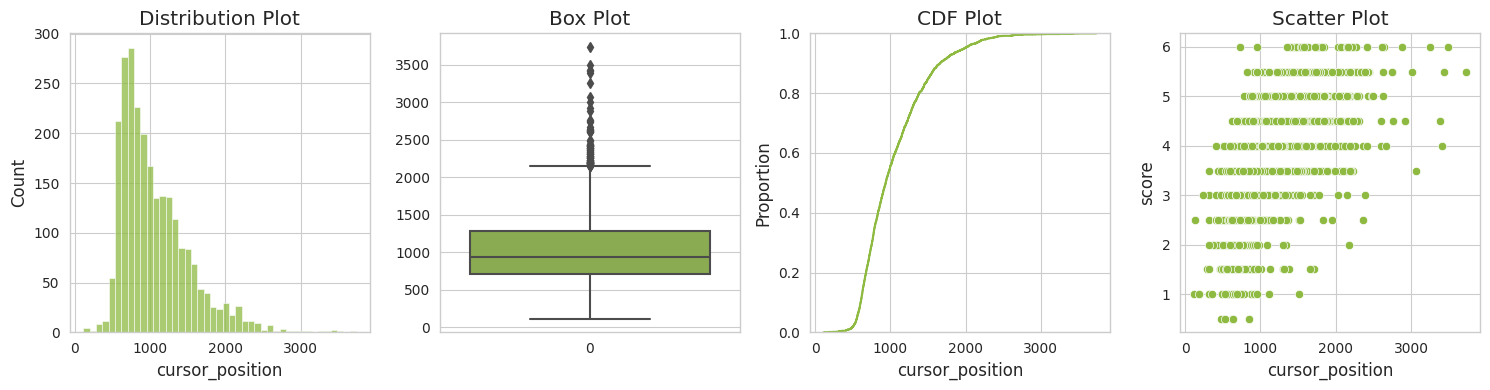

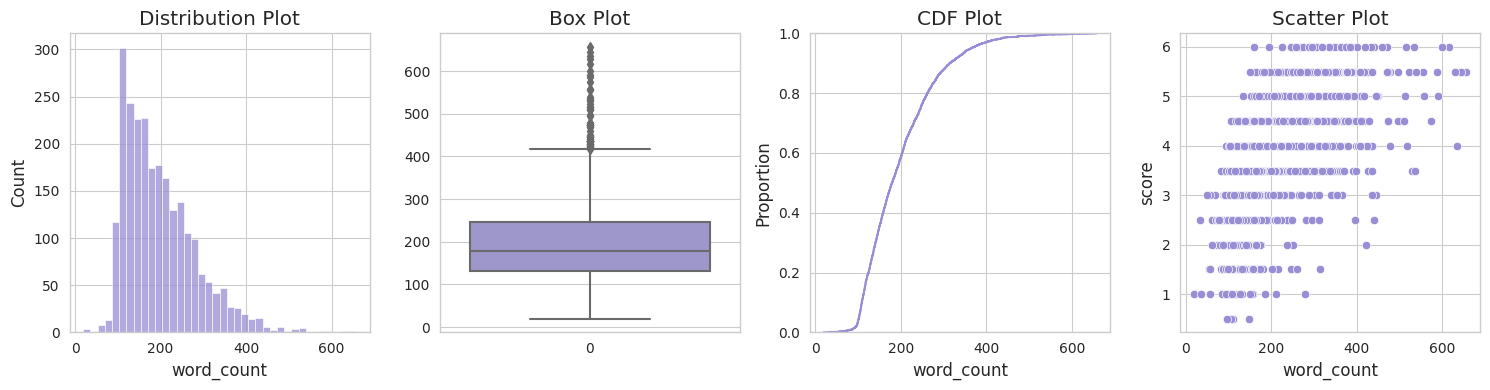

In [21]:
num_cols = ['down_time', 'up_time', 'action_time', 'cursor_position', 'word_count']
for col in num_cols:
  plot_dist_box(train_logs_agg_df[col], train_logs_agg_df['score'])

In [22]:
train_logs['activity'].value_counts()

Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [13, 65] To [9, 61]                   1
Move From [274, 314] To [299, 339]              1
Move From [624, 625] To [845, 846]              1
Move From [1861, 2063] To [1766, 1968]          1
Move From [1766, 1968] To [1861, 2063]          1
Move From [2091, 2179] To [252, 340]            1
Move From [923, 1077] To [340, 494]             1
Move From [0, 1] To [590, 591]                  1
Move From [999, 1000] To [1000, 1001]           1
Move From [0, 75] To [1, 76]                    1
Move From [1651, 1769] To [1565, 1683]          1
Move From [61, 136] To [0, 75]                  1
Move From [623, 632] To [624, 633]              1
Move From [75, 134] To [304, 363]               1


In [23]:
train_logs['down_event'].value_counts()

q             5365319
Space         1207128
Backspace      964089
Shift          334227
ArrowRight     121338
               ...   
F10                 1
Cancel              1
S                   1
T                   1
F6                  1
Name: down_event, Length: 131, dtype: int64

In [24]:
train_logs['up_event'].value_counts()[:100]

q                  5364789
Space              1207128
Backspace           964089
Shift               334227
ArrowRight          121338
Leftclick            91126
ArrowLeft            63217
.                    59586
,                    46806
ArrowDown            30874
ArrowUp              28189
Enter                22689
CapsLock             12568
'                    11170
Delete               10965
Unidentified          6151
Control               4885
"                     4102
-                     3843
?                     3155
;                     1785
=                     1155
Tab                   1081
/                      874
Rightclick             655
:                      634
(                      611
)                      578
\                      554
ContextMenu            552
End                    547
!                      546
Meta                   479
Alt                    466
c                      388
[                      369
v                      313
N

In [25]:
train_logs['text_change'].value_counts()[:100]

q                     6128208
                      1376829
NoChange               703851
.                       67797
,                       54797
\n                      27977
'                       13192
"                        4659
-                        4492
?                        3507
;                        2905
=                        2288
/                        1354
\                        1100
:                         813
(                         733
[                         725
)                         660
!                         639
q => q                    238
qqqq => q                 205
qqq => q                  191
>                         177
qqqqqq => q               165
]                         157
qq => q                   155
qqqqq => q                142
.                         137
qqq  => q                 130
qqqq  => q                120
qqqqqqq => q              114
$                         112
*                         108
qqq       

## (4) Feature Engineering

In [26]:
from collections import defaultdict

class Preprocessor:
  def __init__(self, seed):
    self.seed = seed

    self.activities = ['Input', 'Remove/Cut', 'Nonproduction', 'Replace', 'Paste']
    self.events = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',',
              'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified']
    self.text_changes = ['q', ' ', 'NoChange', '.', ',', '\n', "'", '"', '-', '?', ';', '=', '/', '\\', ':']
    self.punctuations = ['"', '.', ',', "'", '-', ';', ':', '?', '!', '<', '>', '/',
                        '@', '#', '$', '%', '^', '&', '*', '(', ')', '_', '+']
    self.gaps = [1, 2, 3, 5, 10, 20, 50, 100]
    self.idf = defaultdict(float)

  def activity_counts(self, df):
    tmp_df = df.groupby('id').agg({'activity': list}).reset_index()
    ret = list()
    for li in tqdm(tmp_df['activity'].values):
      items = list(Counter(li).items())
      di = dict()
      for k in self.activities:
        di[k] = 0
      for item in items:
        k, v = item[0], item[1]
        if k in di:
          di[k] = v
      ret.append(di)
    ret = pd.DataFrame(ret)
    cols = [f'activity_{i}_count' for i in range(len(ret.columns))]
    ret.columns = cols

    cnts = ret.sum(1)
    for col in cols:
      if col in self.idf.keys():
        idf = self.idf[col]
      else:
        idf = df.shape[0] / (ret[col].sum() + 1)
        idf = np.log(idf)
        self.idf[col] = idf
      ret[col] = 1 + np.log(ret[col] / cnts)
      ret[col] *= idf

    return ret

  def event_counts(self, df, colname):
    tmp_df = df.groupby('id').agg({colname: list}).reset_index()
    ret = list()
    for li in tqdm(tmp_df[colname].values):
      items = list(Counter(li).items())
      di = dict()
      for k in self.events:
        di[k] = 0
      for item in items:
        k, v = item[0], item[1]
        if k in di:
          di[k] = v
      ret.append(di)
    ret = pd.DataFrame(ret)
    cols = [f'{colname}_{i}_count' for i in range(len(ret.columns))]
    ret.columns = cols

    cnts = ret.sum(1)

    for col in cols:
      if col in self.idf.keys():
        idf = self.idf[col]
      else:
        idf = df.shape[0] / (ret[col].sum() + 1)
        idf = np.log(idf)
        self.idf[col] = idf

      ret[col] = 1 + np.log(ret[col] / cnts)
      ret[col] *= idf

    return ret

  def text_change_counts(self, df):
    tmp_df = df.groupby('id').agg({'text_change': list}).reset_index()
    ret = list()
    for li in tqdm(tmp_df['text_change'].values):
      items = list(Counter(li).items())
      di = dict()
      for k in self.text_change:
        di[k] = 0
      for item in items:
        k, v = item[0], item[1]
        if k in di:
          di[k] = v
      ret.append(di)
    ret = pd.DataFrame(ret)
    cols = [f'text_change_{i}_count' for i in range(len(ret.columns))]
    ret.columns = cols

    cnts = ret.sum(1)

  def make_feats(self, df):
    print('Starting to engineer features')

    # initialize features dataframe
    feats = pd.DataFrame({'id': df['id'].unique().tolist()})

    # get shifted features
    print('Engineering time data')
    for gap in self.gaps:
      print(f'> for gap {gap}')
      df[f'up_time_shift{gap}'] = df.groupby('id')['up_time'].shift(gap)
      df[f'action_time_gap{gap}'] = df['down_time'] - df[f'up_time_shift{gap}']
    df.drop(columns=[f'up_time_shift{gap}' for gap in self.gaps], inplace=True)

    # cursor position shift
    print('Engineering cursor position data')
    for gap in self.gaps:
      print(f'> for gap {gap}')
      df[f'cursor_position_shift{gap}'] = df.groupby('id')['cursor_position'].shift(gap)
      df[f'cursor_position_change{gap}'] = df['cursor_position'] - df[f'cursor_position_shift{gap}']
      df[f'cursor_position_abs_change{gap}'] = np.abs(df[f'cursor_position_change{gap}'])
    df.drop(columns=[f'cursor_position_shift{gap}' for gap in self.gaps], inplace=True)

    # word count shift
    print('Engineering word count data')
    for gap in self.gaps:
      print(f'> for gap {gap}')
      df[f'word_count_shift{gap}'] = df.groupby('id')['word_count'].shift(gap)
      df[f'word_count_change{gap}'] = df['word_count'] - df[f'word_count_shift{gap}']
      df[f'word_count_abs_change{gap}'] = np.abs(df[f'word_count_change{gap}'])
    df.drop(columns=[f'word_count_shift{gap}' for gap in self.gaps], inplace=True)

    # get aggregate stastical features
    print('Engineering stastical summaries for features')

    # [(feature name, [stat summaries to add])]
    feats_stat = [
        ('event_id', ['max']),
        ('up_time', ['max']),
        ('action_time', ['sum', 'max', 'mean', 'std']),
        ('activity', ['nunique']),
        ('down_event', ['nunique']),
        ('up_event', ['nunique']),
        ('text_change', ['nunique']),
        ('cursor_position', ['nunique', 'max', 'mean']),
        ('word_count', ['nunique', 'max', 'mean'])
    ]
    for gap in self.gaps:
      feats_stat.extend([
          (f'action_time_gap{gap}', ['max', 'min', 'mean', 'std', 'sum', skew, kurtosis]),
          (f'cursor_position_change{gap}', ['max', 'mean', 'std', 'sum', skew, kurtosis]),
          (f'word_count_change{gap}', ['max', 'mean', 'std', 'sum', skew, kurtosis])
      ])

    pbar = tqdm(feats_stat)
    for item in pbar:
      colname, methods = item[0], item[1]
      for method in methods:
        pbar.set_postfix()
        if isinstance(method, str):
          method_name = method
        else:
          merhod_name = method.__name__

        pbar.set_postfix(column=colname, method=method_name)
        tmp_df = df.groupby(['id']).agg({colname: method}).reset_index().rename(columns={colname: f'{colname}_{method_name}'})
        feats = feats.merge(tmp_df, on='id', how='left')

    # counts
    print('Engineering activity counts data')
    tmp_df = self.activity_counts(df)
    feats = pd.concat([feats, tmp_df], axis=1)

    print('Engineering event counts data')
    tmp_df = self.event_counts(df, 'down_event')
    feats = pd.concat([feats, tmp_df], axis=1)
    tmp_df = self.event_counts(df, 'up_event')
    feats = pd.concat([feats, tmp_df], axis=1)

    print('Engeering text change counts data')
    tmp_df = self.text_change_counts(df)
    feats = pd.concat([feats, tmp_df], axis=1)

    display(feats.head(10))





In [ ]:
print('Engineering features for training data')
preprocessor = Preprocessor(seed=42)
train_feats = preprocessor.make_feats(train_logs)

Engineering features for training data
Starting to engineer features
Engineering time data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering cursor position data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering word count data
> for gap 1
> for gap 2
> for gap 3
> for gap 5
> for gap 10
> for gap 20
> for gap 50
> for gap 100
Engineering stastical summaries for features


 70%|██████▉   | 23/33 [03:38<01:53, 11.39s/it, column=word_count_change10, method=sum]